In [43]:
import numpy as np
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, argmin, argmax, pi, mean, exp, sqrt, zeros, ones, nan
import scipy
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre
from numpy.polynomial import chebyshev

In [44]:

class PCSWE():

    def __init__(self):
        self.debug = False


        # geometry
        self.A = 0.72
        self.H = 7.12 
        self.L = 8e3

        # tunable
        self.r = 0.24
        self.h0 = 0.0025
        self.small_number = nan
        self.bc = nan
        # self.bc = self.bc_moving_boundary


        # morphodynamics
        self.p = 0.4 # porosity
        self.c_d = 0.0025
        self.lmbda = 6.8e-6
        self.d50 = 0.13e-3

        # universal constants
        self.g = 9.81
        self.sigma = 1.4e-4
        self.rho_w = 1025
        self.rho_s = 2650

        self.set_derivative_vars()
        
    def set_derivative_vars(self):
        self.epsilon = self.A / self.H
        self.eta = self.sigma * self.L / sqrt(self.g * self.H)
        self.U = self.epsilon * self.sigma * self.L
        self.kappa = self.g * self.H / (self.sigma * self.L) ** 2

        self.s = self.rho_s / self.rho_w

        self.delta = 0.04 * self.c_d**(3/2) * self.A * (self.sigma * self.L)**4 / \
                    (self.g**2 * (self.s-1)**2 * self.d50 * self.H**6 * (1-self.p))

    def h_fx(self, x): return x
    def h_fx_dx(self, x): return 1 * np.ones(np.array(x).shape)
    def h_fx_dxx(self, x): return 0
    def h_fx_dxxx(self, x): return 0
    
    def deriv_LO(self, x_x, y0_x):
        # x_x, y0_x = np.array(x_x), np.array(y0_x)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)


        if abs(x_x - 1) < 1e-13:
            u0c_x_dx =  ( dz0s_x_dx - u0c_x * h_x_dxx)  / (2*h_x_dx)
            u0s_x_dx =  (-dz0c_x_dx - u0s_x * h_x_dxx)  / (2*h_x_dx)
        else:
            u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
            u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)

   
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_FO(self, x_x, y1_x, y0_x, y0_x_dx):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx= self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x)
            - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x)
            - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x)
            - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa


        # derivatives of u (using continuity equation)
        
        # derivatives of first order u at x = 1 (using l'hopital)
        if abs(x_x - 1) < 1e-13:
            u1r_x_dx, u1c_x_dx, u1s_x_dx = self.lhopital_FO(x_x, y1_x, y0_x, y0_x_dx, (dz1r_x_dx, dz1c_x_dx, dz1s_x_dx))
        else:
            u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
            u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
            u1s_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1s_x + 2 * dz1c_x - 1 / 2 * (dz0s_x * u0c_x_dx + dz0s_x_dx * u0c_x + dz0c_x * u0s_x_dx + dz0c_x_dx * u0s_x))

        # self.product_dxx(x_x, y0_x, y0_x_dx)

        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 
   
    def lhopital_FO(self, x_r, y1_r, y0_r, y0_r_dx, dz1_r_dx):
        dz0c_r, dz0s_r, u0c_r, u0s_r = y0_r
        dz0c_r_dx, dz0s_r_dx, u0c_r_dx, u0s_r_dx = y0_r_dx
        dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r = y1_r
        dz1r_r_dx, dz1c_r_dx, dz1s_r_dx = dz1_r_dx
        h_r, h_r_dx, h_r_dxx, h_r_dxxx = self.h_fx(x_r), self.h_fx_dx(x_r), self.h_fx_dxx(x_r), self.h_fx_dxxx(x_r)

        # second derivatives of leading order components:
        dz0c_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0c_r - self.r / (1 - h_r + self.h0) * u0c_r_dx - u0s_r_dx)
        dz0s_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0s_r - self.r / (1 - h_r + self.h0) * u0s_r_dx + u0c_r_dx)
        u0c_r_dxx = 1/3 * (- h_r_dxx / h_r_dx**2 * ( dz0s_r_dx - u0c_r * h_r_dxx) + 1 / h_r_dx * ( dz0s_r_dxx - u0c_r_dx * h_r_dxx - u0c_r * h_r_dxxx))
        u0s_r_dxx = 1/3 * (- h_r_dxx / h_r_dx**2 * (-dz0c_r_dx - u0s_r * h_r_dxx) + 1 / h_r_dx * (-dz0c_r_dxx - u0s_r_dx * h_r_dxx - u0s_r * h_r_dxxx))

        # second derivatives of products of leading order components:
        dz_u_cc_r_dxx = (dz0c_r * u0c_r_dxx + 2 * dz0c_r_dx * u0c_r_dx + dz0c_r_dxx * u0c_r)
        dz_u_ss_r_dxx = (dz0s_r * u0s_r_dxx + 2 * dz0s_r_dx * u0s_r_dx + dz0s_r_dxx * u0s_r)
        dz_u_cs_r_dxx = (dz0s_r * u0c_r_dxx + 2 * dz0s_r_dx * u0c_r_dx + dz0s_r_dxx * u0c_r)
        dz_u_sc_r_dxx = (dz0c_r * u0s_r_dxx + 2 * dz0c_r_dx * u0s_r_dx + dz0c_r_dxx * u0s_r)

        # l'hopital
        u1r_r_dx = (             - u1r_r * h_r_dxx + (dz_u_cc_r_dxx + dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1c_r_dx = ( 2*dz1s_r_dx - u1c_r * h_r_dxx + (dz_u_cc_r_dxx - dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1s_r_dx = (-2*dz1c_r_dx - u1s_r * h_r_dxx + (dz_u_cs_r_dxx + dz_u_sc_r_dxx) / 2) / (2*h_r_dx)

        return np.array([u1r_r_dx, u1c_r_dx, u1s_r_dx])
       
    def deriv(self, x_x, y_x):
        # print(x_x)
        y0_x, y1_x = np.split(y_x, [4], axis=0)

        y0_x_dx = self.deriv_LO(x_x, y0_x)
        y1_x_dx = self.deriv_FO(x_x, y1_x, y0_x, y0_x_dx)

        y_x_dx = np.concatenate((y0_x_dx, y1_x_dx), axis=0)

        return y_x_dx

    def ivp(self, dz_r, dense_output=False):
        dz0c_r, dz0s_r, dz1r_r, dz1c_r, dz1s_r = dz_r

        
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx

        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)

        u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) + 2 * dz1s_r)
        u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) - 2 * dz1c_r)

        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r


        x_range = [1, 0]
        sol = scipy.integrate.solve_ivp(
            self.deriv,
            x_range,
            y_r,
            rtol=1e-6, atol=1e-6,   
            method='DOP853',
            dense_output=dense_output
        )
        
        return sol

    def solve_shooting(self):
        
        def mismatch(u_r):
            sol = self.ivp(u_r)

            dz0c_l, dz0s_l, u0c_l, u0s_l, dz1r_l, dz1c_l, dz1s_l, u1r_l, u1c_l, u1s_l = sol.y[:, -1]
            return [dz0c_l - 1, dz0s_l, dz1r_l, dz1c_l, dz1s_l]


        dz_guess = 0.001 * np.ones((5))
        res = scipy.optimize.root(mismatch, dz_guess)
        print(res)
        if res.status == 1:
            sol = self.ivp(res.x, dense_output=True)
            return res, sol
    



 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  2.337e-15  3.756e-16  1.848e-15 -3.619e-15]
       x: [ 1.018e+00  1.987e-02  2.010e-04  1.725e-03 -3.742e-02]
  method: hybr
    nfev: 14
    fjac: [[-9.982e-01  1.949e-02 ...  3.055e-04 -5.717e-02]
           [-1.946e-02 -9.998e-01 ...  7.525e-05 -9.915e-04]
           ...
           [-2.587e-03 -6.433e-05 ... -9.992e-01  3.982e-02]
           [ 5.712e-02 -1.256e-04 ... -3.990e-02 -9.976e-01]]
       r: [-9.838e-01 -6.302e-05 ... -1.077e-04 -9.282e-01]
     qtf: [ 8.590e-14  5.780e-15 -9.156e-15 -3.877e-10 -1.535e-11]


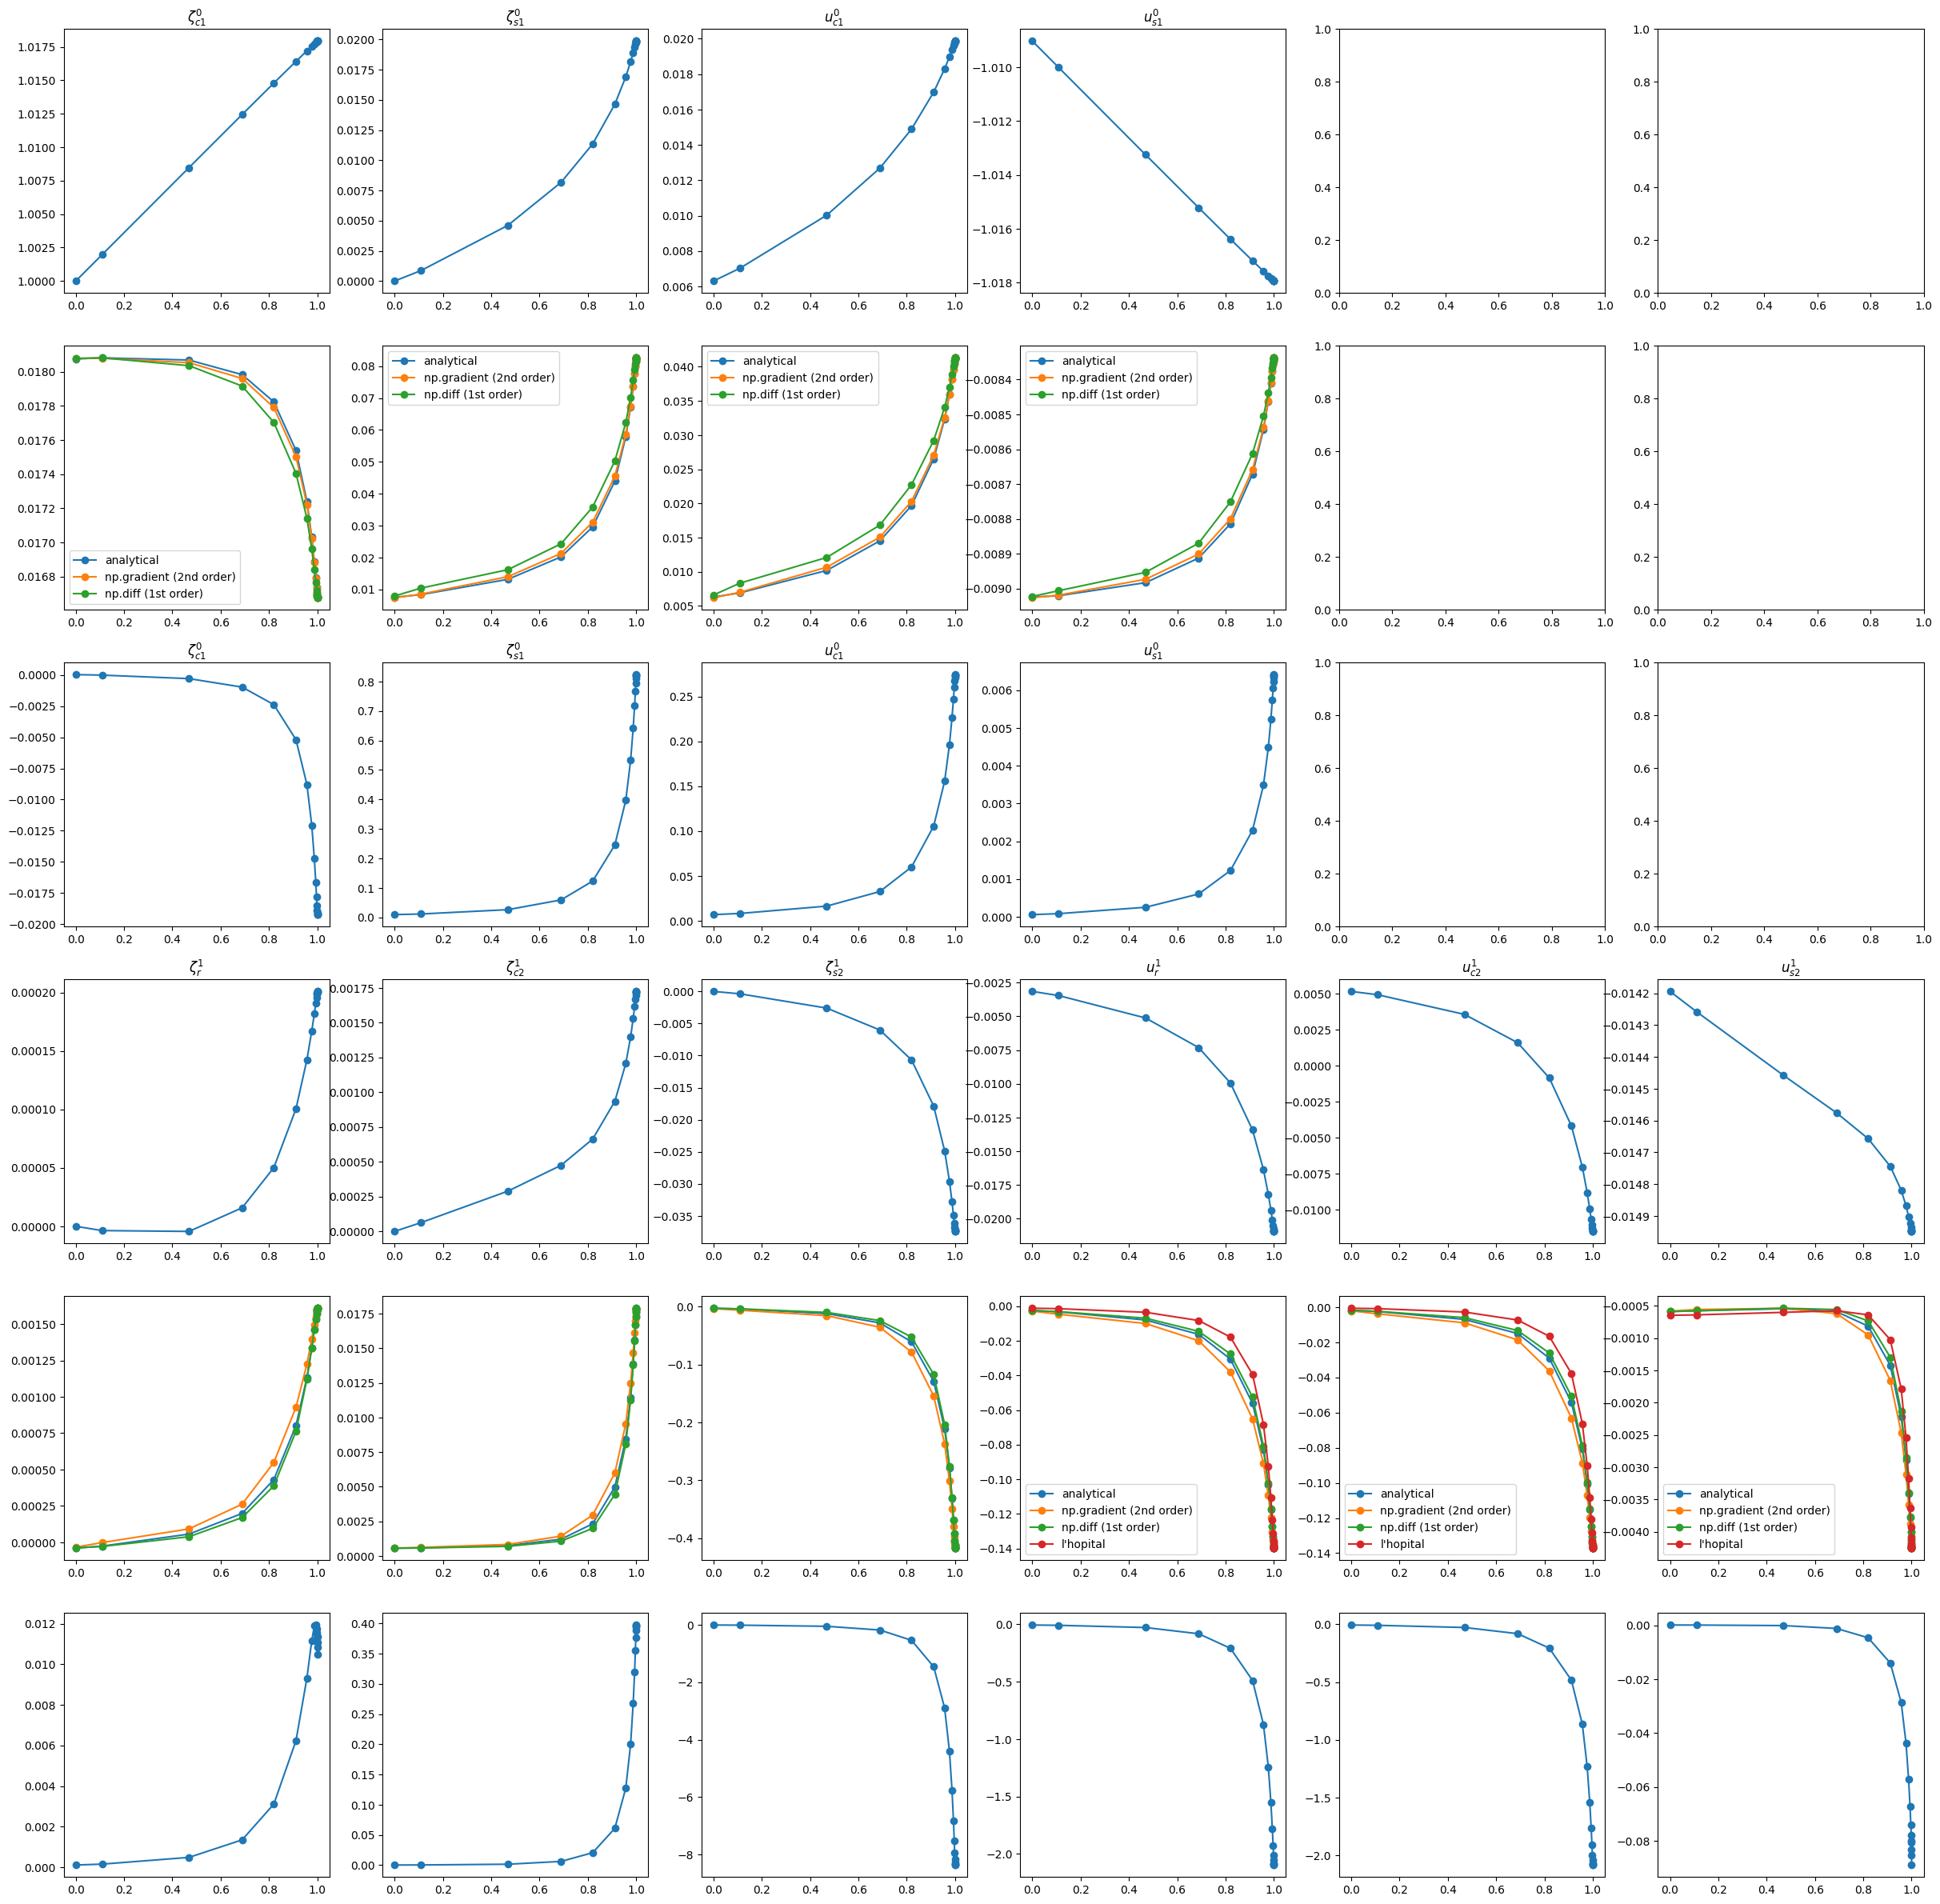

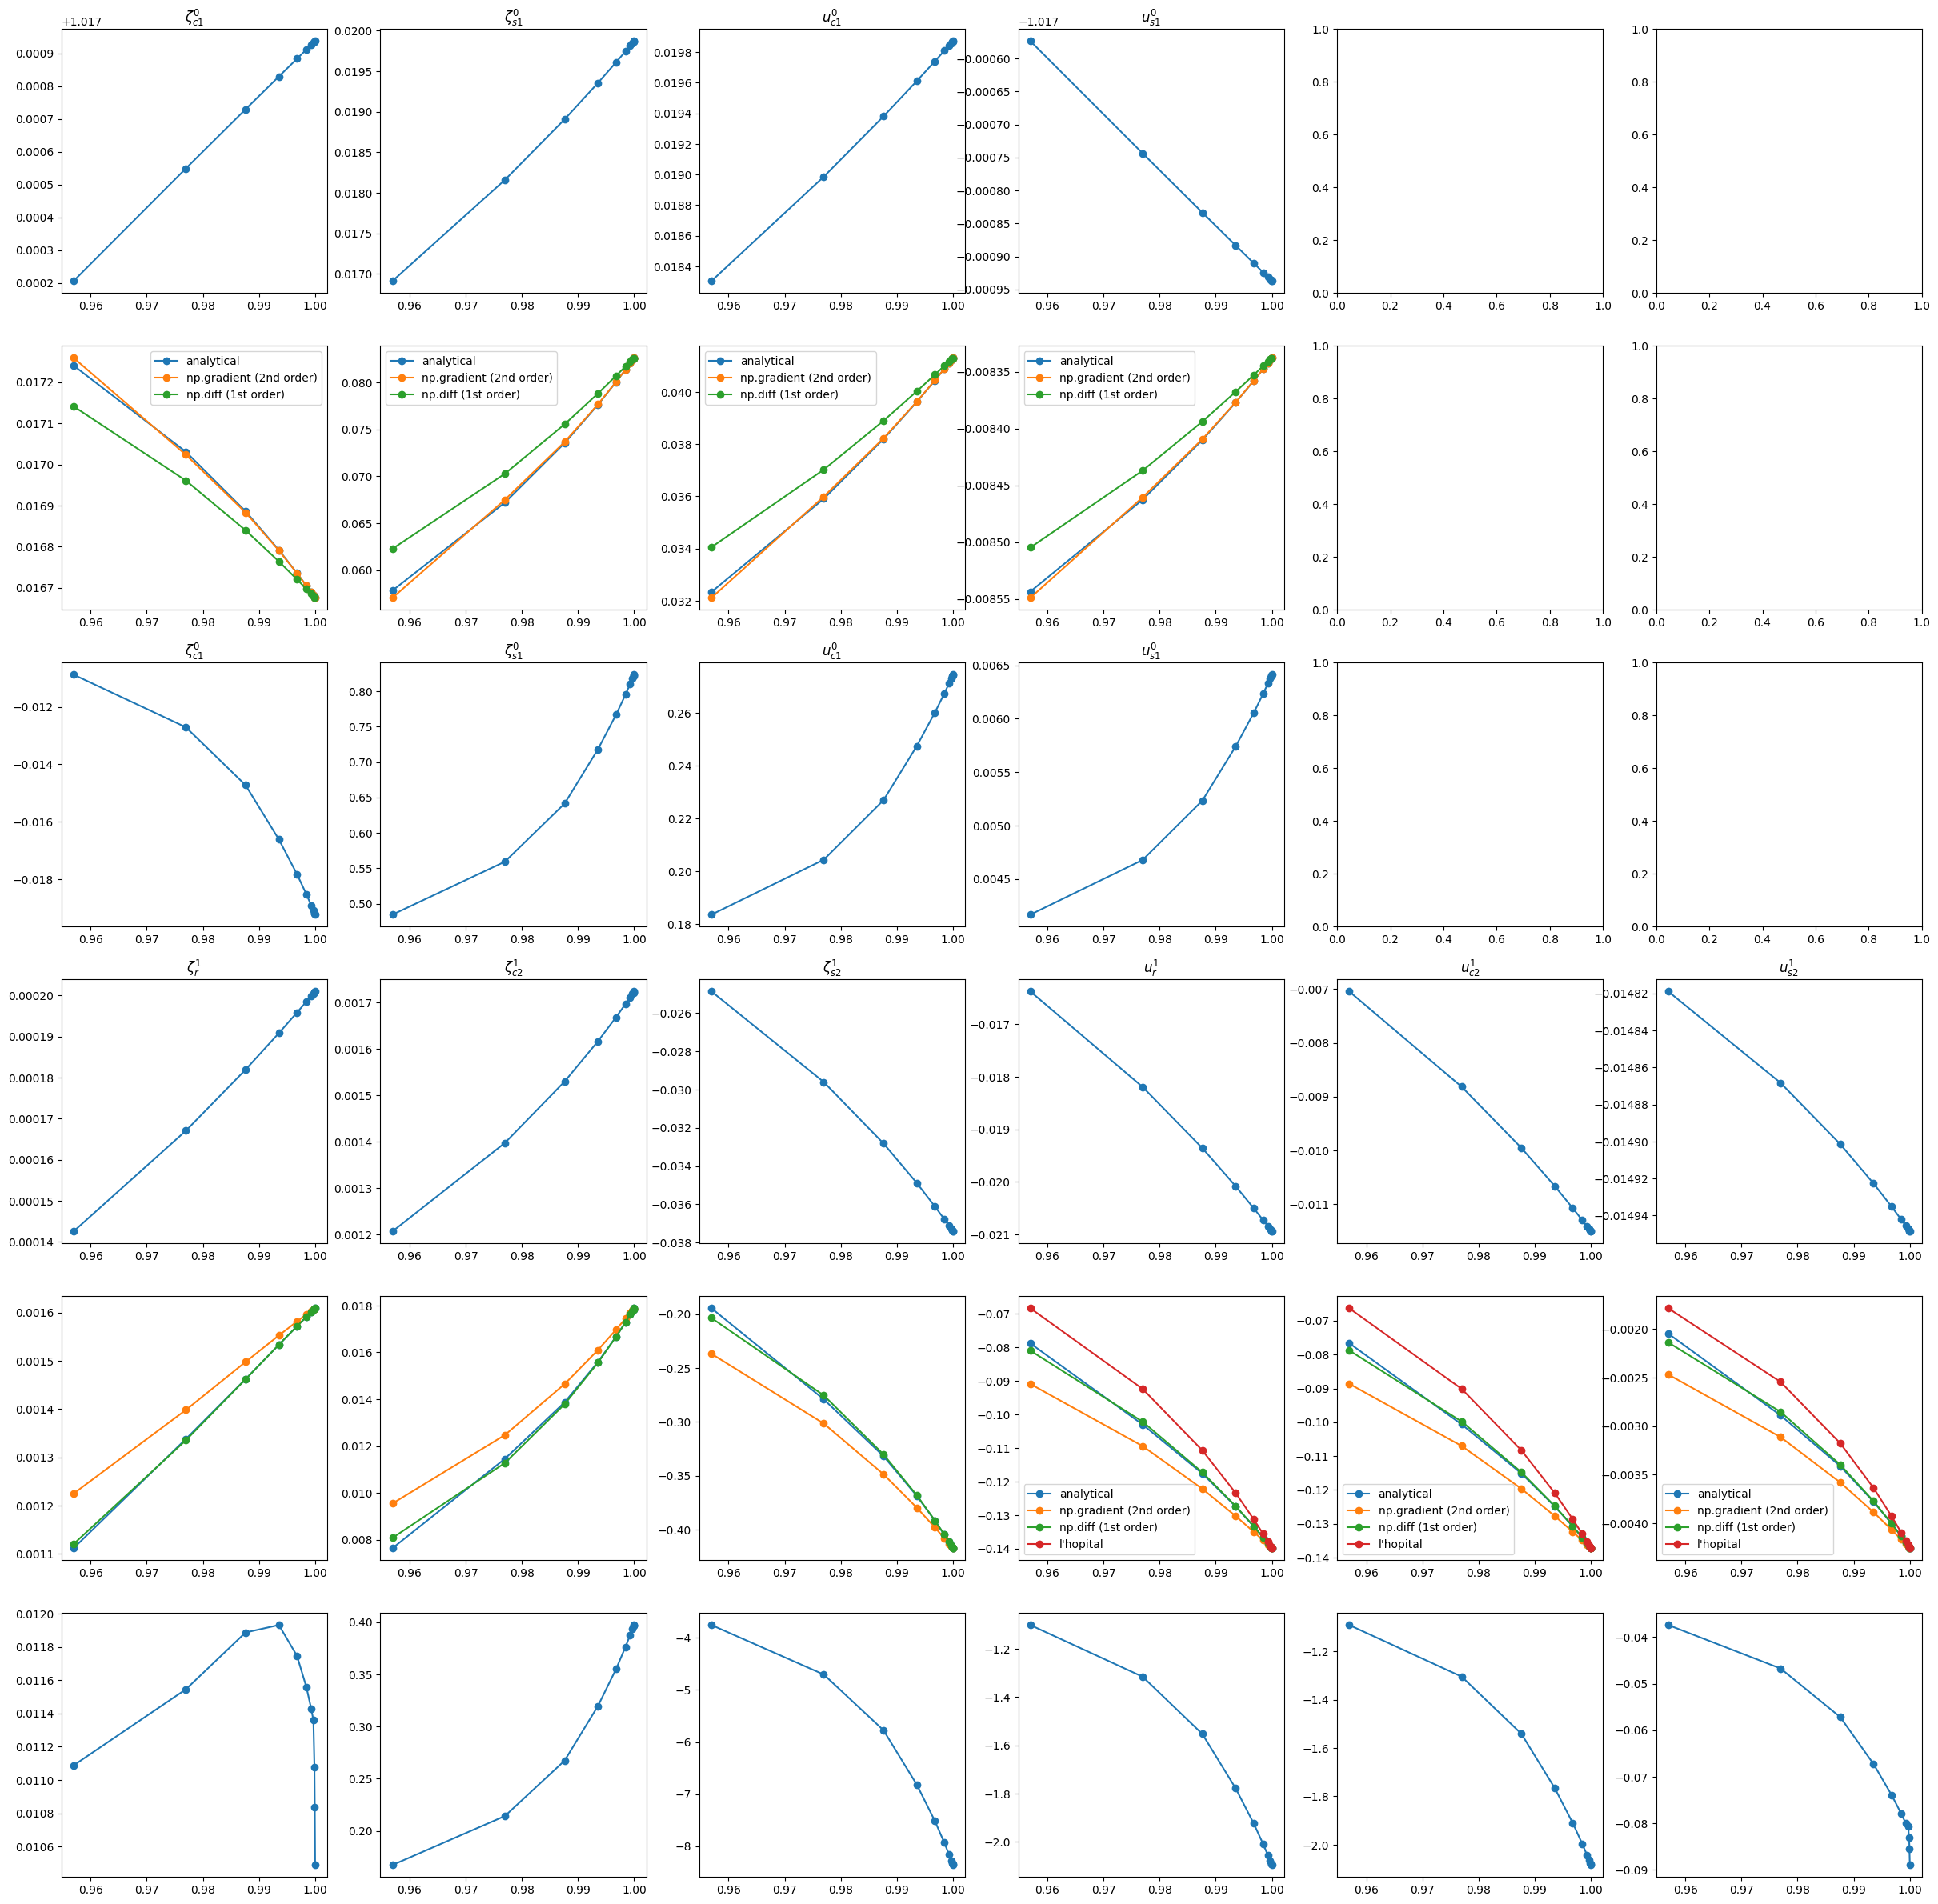

In [45]:
pcswe = PCSWE()
pcswe.h0 = 0.1
pcswe.r = 0.45
pcswe.small_number = 0
pcswe.tol = 1e-5
pcswe.set_derivative_vars()
res, sol = pcswe.solve_shooting()

def make_plot(x, y):

    fig, axs = plt.subplots(6, 6, figsize=(30, 30))
    labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]

    y_x_dx = np.array([pcswe.deriv(x_, sol.sol(x_)) for x_ in x]).T
    u1_x_dx = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x, y.T, y_x_dx.T)]).T

    for i in range(4):
        axs[0, i].set_title(labels[i])
        axs[0, i].plot(x, y[i],'o-')
    for i in range(4):
        
        axs[1, i].plot(x, y_x_dx[i], 'o-')
        axs[1, i].plot(x, np.gradient(y[i], x, edge_order=2),'o-')
        axs[1, i].plot(x[1:], np.diff(y[i]) / np.diff(x),'o-')
        axs[1, i].legend(["analytical", "np.gradient (2nd order)", "np.diff (1st order)"])
    for i in range(4):
        axs[2, i].set_title(labels[i])
        axs[2, i].plot(x, np.gradient(np.gradient(y[i], x, edge_order=2), x, edge_order=2),'o-')
    for i in range(6):
        axs[3, i].set_title(labels[4+i])
        axs[3, i].plot(x, y[4+i],'o-')
    for i in range(6):
        
        axs[4, i].plot(x[:], np.gradient(y[4+i], x, edge_order=2)[:],'o-')
        axs[4, i].plot(x[1:], (np.diff(y[4+i]) / np.diff(x))[:],'o-')
        axs[4, i].plot(x[:], y_x_dx[4+i][:], 'o-')
    for i in range(3):
        axs[4, 3+i].plot(x, u1_x_dx[i], 'o-')
        axs[4, 3+i].legend(["analytical", "np.gradient (2nd order)", "np.diff (1st order)", "l'hopital"])

    for i in range(6):
        axs[5, i].plot(x, np.gradient(np.gradient(y[4+i], x, edge_order=2), x, edge_order=2),'o-')
    plt.show()


x, y = sol.t, sol.y
make_plot(x, y)

x = sol.t[sol.t > 0.95]
y = sol.y[:, sol.t > 0.95]
make_plot(x, y)
